# Środowiska ciągłe
### Katarzyna Stępień, Alicja Wójcik, Kacper Stankiewicz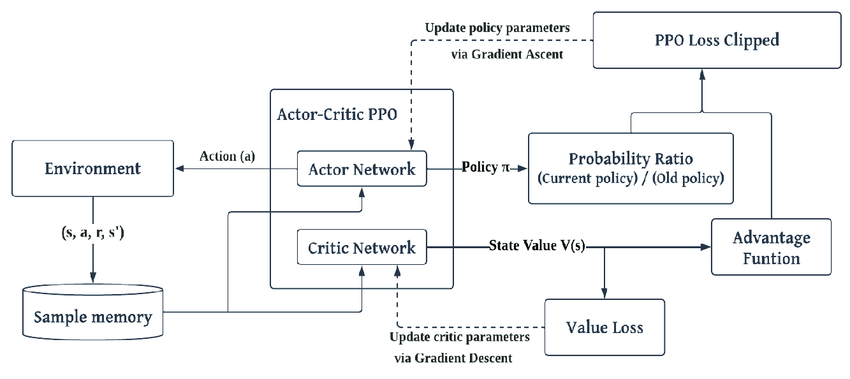

In [5]:
# for autoformatting
# %load_ext jupyter_black

In [ ]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install "stable-baselines3[extra]>=2.0.0a4"

## Ważniejsze biblioteki

In [71]:
import gymnasium as gym
import numpy as np

In [72]:
from stable_baselines3 import PPO

In [73]:
from stable_baselines3.ppo.policies import MlpPolicy
from gymnasium import Env
from stable_baselines3.common.base_class import BaseAlgorithm
from stable_baselines3.common.evaluation import evaluate_policy

In [ ]:
from typing import Dict
from dataclasses import dataclass, asdict, field

In [ ]:
import matplotlib.pyplot as plt
import time

## Uczenie modelu

W projekcie wykorzystaliśmy ciągłą wersję środowiska MountainCar.

MDP Mountain Car to deterministyczne środowisko Markowa (MDP) 2D, w którym umieszczony jest samochód na dole sinusoidalnej doliny. Jedyne dostępne akcje to przyspieszenia, które można zastosować do samochodu w dwóch dostępnych kierunkach (przód-tył samochodu). Celem MDP jest strategiczne przyspieszenie samochodu, tak, aby osiągnąć stan docelowy na szczycie prawego wzgórza. W bibliotece Gymnasium istnieją dwie wersje tego środowiska: jedna z dyskretnymi akcjami i druga z ciągłymi. Wersja użyta w tym projekcie korzysta z ciągłych akcji.

In [74]:
env = gym.make("MountainCarContinuous-v0")

Do usprawnienia manipulacji hiperparametrów stworzyliśmy klasę pomocniczą, z domyślnymi wartościami parametrów ustawionymi według rekomendacji [repozytorium RL Zoo](https://github.com/DLR-RM/rl-baselines3-zoo)

In [75]:
@dataclass
class Params:
  normalize_advantage: bool = True
  policy: str = "MlpPolicy"
  batch_size: int = 32
  n_steps: int = 32
  gamma: float = 0.9999
  learning_rate: float = float(7.77e-05)
  ent_coef: float = 0.00429
  clip_range: float = 0.1
  n_epochs: int = 100
  gae_lambda: float = 0.9
  max_grad_norm: int = 5
  vf_coef: float = 0.19
  use_sde: bool = True
  policy_kwargs: Dict = field(default_factory=lambda: dict(log_std_init=-3.29, ortho_init=False))

W bibliotece stable_baselines dostępna jest już wyspecjalizowana funkcja do ewaluacji efektów uczenia modelu. Na potrzeby zadania wykorzystaliśmy ją do zbierania statystyk.

In [95]:
def evaluate_and_plot(model: BaseAlgorithm, env: Env, n_eval_episodes: int, warn: bool, deterministic:bool, repeat: int):
  rewards = []
  std_rewards = []
  total_time = 0
  for i in range(repeat):
    start_time = time.time()
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes, deterministic)
    end_time = time.time() - start_time
    rewards.append(mean_reward)
    std_rewards.append(std_reward)
    print(f"Iteration: {i+1}, Evaluation time: {end_time}")
    total_time += end_time
  print(f"Total evaluation time: {total_time}")

  plt.figure(figsize=(10, 5))  # Set the figure size
  fig, ax = plt.subplots(1, 2)
  y, x = zip(*[(reward, index) for index, reward in enumerate(rewards)])

  ax[0].plot(list(x), list(y), "-b", label="mean reward")
  ax[1].plot(list(x), std_rewards, "-r", label="std deviation")
  ax[0].legend(loc="upper left")
  ax[1].legend(loc="upper left")

  plt.xlabel('Episode')

  plt.title('Rewards per Episode - Mountain cart continuous PPO')
  plt.savefig('rewards_plot_ppo.png')
  plt.show()


### Wizualizacja uczenia - nagranie wideo


In [78]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [79]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay


def show_videos(video_path="", prefix=""):
    """
    Taken from https://github.com/eleurent/highway-env

    :param video_path: (str) Path to the folder containing videos
    :param prefix: (str) Filter the video, showing only the only starting with this prefix
    """
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            """<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>""".format(
                mp4, video_b64.decode("ascii")
            )
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Do "nagrania" wideo wykorzystany został wrapper VecVideoRecorder.

In [80]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv


def record_video(env_id, model, video_length=500, prefix="", video_folder="videos/"):
    """
    :param env_id: (str)
    :param model: (RL model)
    :param video_length: (int)
    :param prefix: (str)
    :param video_folder: (str)
    """
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Start the video at step=0 and record 500 steps
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )

    obs = eval_env.reset()
    for _ in range(video_length):
        action, _ = model.predict(obs)
        obs, _, _, _ = eval_env.step(action)

    # Close the video recorder
    eval_env.close()

## Uczenie modelu wraz z wizualizacją statystyk oraz nagranie zachowania agenta




In [98]:
def create_model_and_evaluate(params, env, learning_steps, repeat, policy_kwargs = None, filename = "ppo-mountain-car", deterministic=False):
  merged_dict = asdict(params) | {"env": env}
  if policy_kwargs is not None:
    merged_dict = merged_dict | {"policy_kwargs": policy_kwargs}

  model = PPO(**merged_dict)

  start_time = time.time()
  model.learn(total_timesteps=learning_steps)
  end_time = time.time() - start_time
  print(f"Total learning time: {end_time}")

  evaluate_and_plot(model, env, n_eval_episodes=100, warn=False, deterministic=deterministic, repeat=repeat)

  record_video("MountainCarContinuous-v0", model, video_length=2000, prefix=filename)

  return model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Parametry domyślne

In [ ]:
params = Params()
model1 = create_model_and_evaluate(params, env, 50_0000, 10, filename="ppo-mountain-car-hipar-0")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Różne wariacje hiperparapmetrów

Parmetry zmienione w tym eksperymencie:
- learning_rate - Wpływa na to, jak bardzo wagi lub parametry modelu są dostosowywane w każdej iteracji

- gamma - jak daleko w przyszłość uwzględniamy nagrody

- ent_coef - W PPO współczynnik entropii wpływa na regulację entropii polityki (losowość akcji)

- gae_lambda - GAE to metoda szacowania funkcji przewagi w uczeniu ze wzmocnieniem, która mierzy, o ile lepsza jest pewna akcja w porównaniu do średniej akcji

In [ ]:
params = Params(learning_rate = float(7.77e-03), gamma=0.89, ent_coef=0.003, gae_lambda = 0.99)
model2 = create_model_and_evaluate(params, env, 50_000, 10, filename="ppo-mountain-car-hipar-1")

Parametry zmienione w tym eksperymencie:
- n_steps - ilość krków, jaką agent musi wykonać na każdy update

- vf_coef - kontroluje, jak bardzo uwzględniamy funkcję wartości w optymalizacji polityki

- clip_range - wpływa na wartość gradientu

In [ ]:
params = Params(n_steps=16, n_epochs = 50, vf_coef = 0.24, clip_range = 0.15)
model3 = create_model_and_evaluate(params, env, 50_000, 10, filename="ppo-mountain-car-hipar-2")

(Wygenerowane filmiki zostaną załączone w osobnym pliku)

In [ ]:
show_videos("videos", prefix="ppo-mountain-car-hipar")

## Eksperymenty z różnymi architekturami sieci

### Domyślnie wykorzystywana sieć - MlpPolicy

**PPO** jest metodą policy gradient, co oznacza, że bezpośrednio optymalizuje politykę agenta. Funkcja polityki agenta to sieć neuronowa, która jest aktualizowana (dość powoli, w celu ograniczenia popełniania złych decyzji przez agenta, prowadzących w zupełnie innym kierunku) na podstawie rezultatów podejmowanych akcji i przyznawanych za nie nagród.

PPO zawiera w sobie dwa modele, aktora i krytyka, o dwóch różnych architekturach, co widać na obrazku niżej:

![ppo](https://drive.google.com/uc?export=view&id=1PlRHtfXZJ_iRZ1r1arA_TJSLXrcLe7Zx)

Nasza początkowa sieć wykorzystuje dwie gęste warstwy w modelu aktora oraz krytyka (jest to wartość domyślna). Wszystkie mają po 64 neurony. Funkcja aktywacji to ReLu.

![ppo64](https://drive.google.com/uc?export=view&id=1n2I87Pjq6eTTdiBRdETZbYbneooHPYxp)

### Modyfikacja 1

W tym wypadku architektura modelu aktora wygląda następująco:

![actor32](https://drive.google.com/uc?export=view&id=1bxh5-LoWJJOuBkRf_ybrWZhI_0-IxQd9)

Natomiast krytyka:

![critic1688](https://drive.google.com/uc?export=view&id=1dRZK6--kLZwciB3UbZvn6bbBnZVi4Avx)

### Modyfikacja 2

W tym wypadku architektura modelu aktora wygląda następująco:


![actor161616](https://drive.google.com/uc?export=view&id=14MBXugWXMWb6aAtkPIlVTR3Udg2Qshgb)

Natomiast krytyka:

![critic88](https://drive.google.com/uc?export=view&id=1X_OEjNFUK4d2ek3ZAUb2ip7WtvIersI_)

### Modyfikacja pierwsza

In [86]:
import torch as th

In [87]:
params = Params()
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi=[32], vf=[16, 8, 8]))
create_model_and_evaluate(params, env, 1_000, 10, policy_kwargs, filename="ppo-mountain-car-arch-1")

Total learning time: 16.48314070701599
Iteration: 1, Evaluation time: 62.57222270965576
Iteration: 2, Evaluation time: 81.84483122825623


KeyboardInterrupt: 

### Modyfikacja druga

In [ ]:
params = Params()
policy_kwargs = dict(activation_fn=th.nn.Tanh,
                     net_arch=dict(pi=[16, 16, 16], vf=[8, 8]))
create_model_and_evaluate(params, env, 50_000, 10, policy_kwargs, filename="ppo-mountain-car-arch-2")

## Obserwacja zachowania agenta z wyłączonym trybem eksploracji